In [ ]:
import pandas as pd
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, lpDot, value, LpStatus

# 读取预处理后的数据
data = pd.read_excel("预处理后的数据.xlsx")

# 确保数据中所有需要的列都有值
required_columns = ["作物名称", "平均价", "亩产量/斤", "种植成本/(元/亩)", "作物类型"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("数据缺少必要的列")

# 提取相关数据
years = range(2024, 2031)
crops = data["作物名称"].unique()
plots = data["地块名称"].unique()

# 蒙特卡洛模拟次数
num_simulations = 100

# 存储结果的字典
results = {}
for t in years:
    results[t] = pd.DataFrame(0, index=plots, columns=crops)

# 蒙特卡洛模拟
for _ in range(num_simulations):
    # 假设预计销售量相对于 2023 年保持稳定
    data["预计销售量"] = data.groupby("作物名称")["种植面积/亩"].transform("sum")

    # 处理小麦和玉米的预期销售量增长
    wheat_corn_data = data[(data["作物名称"] == "小麦") | (data["作物名称"] == "玉米")]
    growth_rate = np.random.uniform(0.05, 0.1)
    wheat_corn_data["预计销售量"] *= (1 + growth_rate)**(years[0] - 2023)

    # 处理其他农作物的预期销售量变化
    other_crops_data = data[~data["作物名称"].isin(["小麦", "玉米"])]
    change_rate = np.random.uniform(-0.05, 0.05)
    other_crops_data["预计销售量"] *= (1 + change_rate)

    # 处理农作物亩产量的变化
    yield_change_rate = np.random.uniform(-0.1, 0.1)
    data["亩产量/斤"] *= (1 + yield_change_rate)

    # 处理种植成本的增长
    cost_growth_rate = 0.05
    data["种植成本/(元/亩)"] *= (1 + cost_growth_rate)**(years[0] - 2023)

    # 处理蔬菜类作物销售价格增长
    vegetable_crops_data = data[data["作物类型"].str.startswith("蔬菜")]
    price_growth_rate = 0.05
    vegetable_crops_data["平均价"] *= (1 + price_growth_rate)**(years[0] - 2023)

    # 处理食用菌销售价格下降
    mushroom_crops_data = data[data["作物类型"].str.startswith("食用菌")]
    if "羊肚菌" in mushroom_crops_data["作物名称"].values:
        price_decline_rate = 0.05
    else:
        price_decline_rate = np.random.uniform(0.01, 0.05)
    mushroom_crops_data["平均价"] *= (1 - price_decline_rate)**(years[0] - 2023)

    # 定义问题
    prob = LpProblem("Problem", LpMaximize)

    # 定义变量
    x = LpVariable.dicts("x", [(i, j, t) for i in plots for j in crops for t in years], lowBound=0, cat='Continuous')

    # 设定目标函数
    for j in crops:
        for t in years:
            crop_data = data.loc[data["作物名称"] == j].iloc[0]
            profit_per_unit = crop_data["平均价"] * crop_data["亩产量/斤"] - crop_data["种植成本/(元/亩)"]
            prob += lpDot([x[i, j, t] for i in plots], profit_per_unit)

    # 设定约束条件
    # 耕地资源约束
    for t in years:
        prob += lpSum([x[i, j, t] for i in plots for j in crops]) <= 1201

    # 种植间作的要求：同一地块同一季节不能种植两种粮食类作物
    for i in plots:
        for t in years:
            grain_crops = [j for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食")]
            prob += lpSum([x[i, j, t] for j in grain_crops]) <= 1

    # 豆类作物轮作要求：每个地块三年内至少种植一次豆类作物
    for i in plots:
        for t in years:
            if t <= 2026:
                prob += lpSum([x[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）")]) >= 1

    for i in plots:
        if data.loc[data["地块名称"] == i, "地块类型"].values[0] == "水浇地":
            for t in years:
                prob += lpSum([x[i, j, t] for j in crops if j == "水稻" or data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("蔬菜")]) <= 1
        else:
            for t in years:
                prob += lpSum([x[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食") and j!= "水稻"]) <= 1

    # 提升非豆类作物的最低种植面积
    for j in crops:
        for t in years:
            if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）"):
                prob += lpSum([x[i, j, t] for i in plots]) >= 30  # 设定非豆类作物最低种植面积
    for j in crops:
        for t in years:
            if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食"):
                prob += lpSum([x[i, j, t] for i in plots]) >= 20  # 设定非豆类作物最低种植面积

    # 确保每个地块每年都有种植作物
    for i in plots:
        for t in years:
            prob += lpSum([x[i, j, t] for j in crops]) >= 0.6  # 确保每个地块每年都至少种植0.3亩作物

    # 求解问题
    prob.solve()

    # 提取结果
    result = pd.DataFrame([(i, j, t, value(x[i, j, t])) for i in plots for j in crops for t in years if value(x[i, j, t]) > 0], columns=["地块名称", "作物名称", "年份", "种植面积/亩"])

    two_season = ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8",
                    "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8",
                    "E9", "E10", "E11", "E12", "E13", "E14", "E15", "E16",
                    "F1", "F2", "F3", "F4"]

    # 确保地块名称的列名正确
    result = result.rename(columns={"地块名称": "地块名称"})

    # 筛选出包含 two_season 中地块名称的行
    result_two_season = result[result["地块名称"].isin(two_season)]

    # 分离出第一季和第二季的数据
    season1_df = result_two_season[result_two_season["地块名称"].isin(two_season) & (result_two_season["年份"] % 2 == 0)].copy()
    season1_df['季节'] = "第一季"

    season2_df = result_two_season[result_two_season["地块名称"].isin(two_season) & (result_two_season["年份"] % 2 == 1)].copy()
    season2_df['季节'] = "第二季"

    # 合并第一季和第二季的数据
    result_two_season = pd.concat([season1_df, season2_df])

    # 处理其他地块的第一季数据
    season1_df_other = result[~result["地块名称"].isin(two_season)].copy()
    season1_df_other['季节'] = "第一季"

    # 合并所有数据
    result = pd.concat([season1_df_other, result_two_season])
    result.reset_index(drop=True, inplace=True)

    # 更新结果字典
    for _, row in result.iterrows():
        plot_name = row["地块名称"]
        crop_name = row["作物名称"]
        year = row["年份"]
        planting_area = row["种植面积/亩"]
        results[year].loc[plot_name, crop_name] += planting_area

# 平均结果
for t in years:
    results[t] /= num_simulations

# 保存结果
with pd.ExcelWriter("result2.xlsx") as writer:
    for t, df in results.items():
        df.to_excel(writer, sheet_name=str(t))

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, lpDot, value, LpStatus

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取预处理后的数据
data = pd.read_excel("预处理后的数据.xlsx")

# 提取相关数据
years = range(2024, 2031)
crops = data["作物名称"].unique()
plots = data["地块名称"].unique()

# 蒙特卡洛模拟次数
num_simulations = 10

# 存储结果的字典
results = {}
for t in years:
    results[t] = pd.DataFrame(0, index=plots, columns=crops)

# 蒙特卡洛模拟
for _ in range(num_simulations):
    # 假设预计销售量相对于 2023 年保持稳定
    data["预计销售量"] = data.groupby("作物名称")["种植面积/亩"].transform("sum")

    # 处理小麦和玉米的预期销售量增长
    wheat_corn_data = data[(data["作物名称"] == "小麦") | (data["作物名称"] == "玉米")]
    growth_rate = np.random.uniform(0.05, 0.1)
    wheat_corn_data["预计销售量"] *= (1 + growth_rate)**(years[0] - 2023)

    # 处理其他农作物的预期销售量变化
    other_crops_data = data[~data["作物名称"].isin(["小麦", "玉米"])]
    change_rate = np.random.uniform(-0.05, 0.05)
    other_crops_data["预计销售量"] *= (1 + change_rate)

    # 处理农作物亩产量的变化
    yield_change_rate = np.random.uniform(-0.1, 0.1)
    data["亩产量/斤"] *= (1 + yield_change_rate)

    # 处理种植成本的增长
    cost_growth_rate = 0.05
    data["种植成本/(元/亩)"] *= (1 + cost_growth_rate)**(years[0] - 2023)

    # 处理蔬菜类作物销售价格增长
    vegetable_crops_data = data[data["作物类型"].str.startswith("蔬菜")]
    price_growth_rate = 0.05
    vegetable_crops_data["平均价"] *= (1 + price_growth_rate)**(years[0] - 2023)

    # 处理食用菌销售价格下降
    mushroom_crops_data = data[data["作物类型"].str.startswith("食用菌")]
    if "羊肚菌" in mushroom_crops_data["作物名称"].values:
        price_decline_rate = 0.05
    else:
        price_decline_rate = np.random.uniform(0.01, 0.05)
    mushroom_crops_data["平均价"] *= (1 - price_decline_rate)**(years[0] - 2023)

    # 计算每年每个作物的销售量
    for t in years:
        for crop in crops:
            if crop in wheat_corn_data["作物名称"].values:
                results[t].loc[wheat_corn_data["地块名称"], crop] += wheat_corn_data.loc[wheat_corn_data["作物名称"] == crop, "预计销售量"].values[0]

            elif crop in other_crops_data["作物名称"].values:
                results[t].loc[other_crops_data["地块名称"], crop] += other_crops_data.loc[other_crops_data["作物名称"] == crop, "预计销售量"].values[0]
            else:
                raise ValueError("数据中不存在该作物")

# 计算平均销售量

for t in years:
    results[t] = results[t].apply(lambda x: x / num_simulations)

# # 计算总销售量
# total_sales = pd.DataFrame(0, index=plots, columns=years)
# for t in years:
#     total_sales[t] = results[t].sum(axis=1)

# 计算总亩产量
total_yield = pd.DataFrame(0, index=plots, columns=years)
for t in years:
    total_yield[t] = data.groupby("地块名称")["亩产量/斤"].transform("sum")

# 计算总成本
total_cost = pd.DataFrame(0, index=plots, columns=years)
for t in years:
    total_cost[t] = data.groupby("地块名称")["种植成本/(元/亩)"].transform("sum")



C:\Users\jiang\AppData\Local\Temp\ipykernel_5088\2192917719.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_corn_data["预计销售量"] *= (1 + growth_rate)**(years[0] - 2023)
C:\Users\jiang\AppData\Local\Temp\ipykernel_5088\2192917719.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_crops_data["预计销售量"] *= (1 + change_rate)
C:\Users\jiang\AppData\Local\Temp\ipykernel_5088\2192917719.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

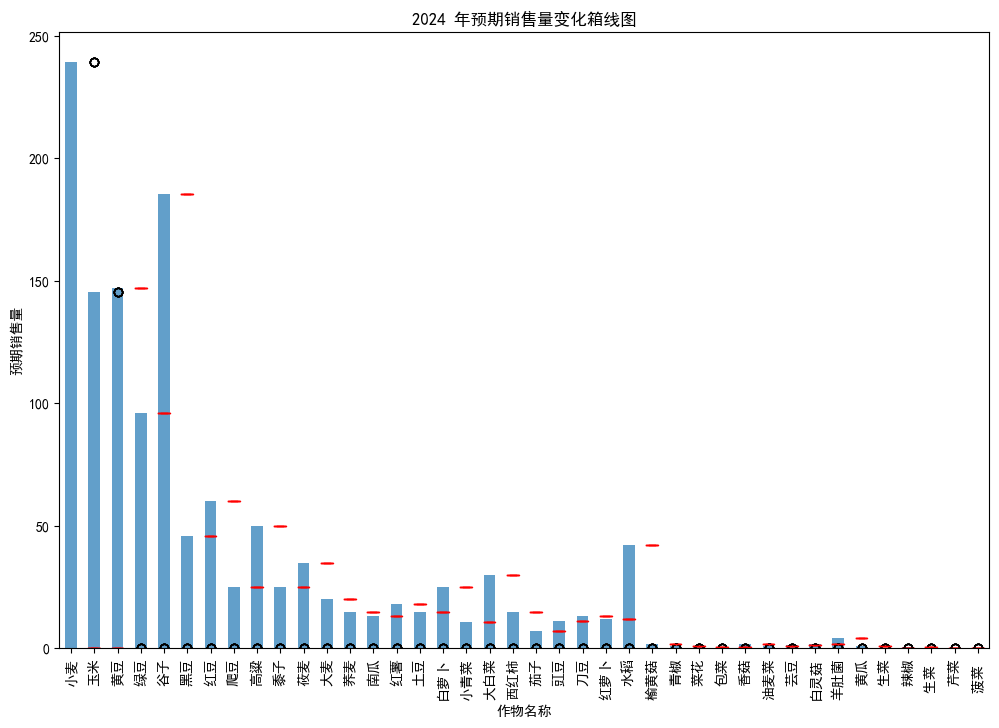

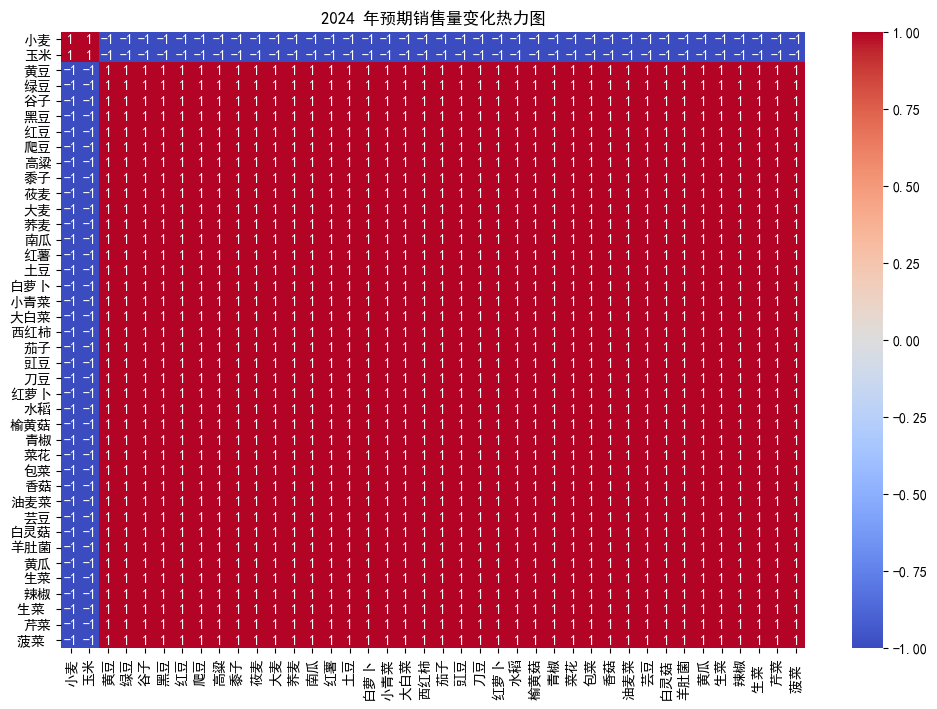

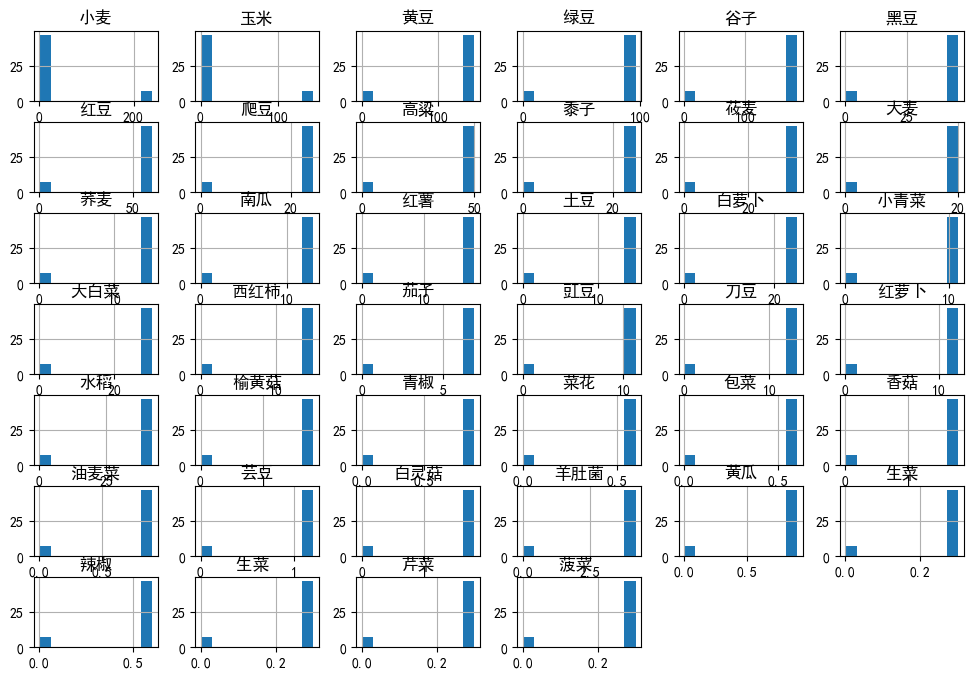

In [56]:
import seaborn as sns
# 提取 2024 年的数据
data_2024 = results[2024]
# selected_crops = ['黄豆', '水稻', '豇豆', '油麦菜', '香菇']
# data_2024 = data_2024[selected_crops]
# print(data_2024.head())
# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制箱线图
data_2024.boxplot(color='r')
data_2024.max().plot(kind='bar', alpha=0.7)
# 设置标题和标签
plt.title("2024 年预期销售量变化箱线图")
# plt.ylim(-1000, 1000)
plt.xlabel("作物名称")
plt.ylabel("预期销售量")

# 显示图形
plt.show()

# mushroom_crops_data = data_2024.iloc[:, :-1]
# mushroom_crops_data.plot(kind='bar', stacked=True, figsize=(12, 8))
# plt.title("2024 年预期销售量变化柱状图")
# # plt.ylim(0, 1000)
# plt.xlabel("作物名称")
# plt.ylabel("预期销售量")
# plt.show()

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(data_2024.corr(), annot=True, cmap='coolwarm')
plt.title("2024 年预期销售量变化热力图")
plt.show()


# # 绘制散点图
# sns.pairplot(data_2024)
# plt.title("2024 年预期销售量变化散点图")
# plt.show()

data_2024.hist(figsize=(12, 8))
plt.title("2024 年预期销售量变化直方图")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pulp import LpMaximize, LpProblem, LpVariable, lpSum, lpDot, value, LpStatus

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取预处理后的数据
data = pd.read_excel("预处理后的数据.xlsx")

# 提取相关数据
years = range(2024, 2031)
crops = data["作物名称"].unique()
plots = data["地块名称"].unique()

# 蒙特卡洛模拟次数
num_simulations = 10

# 存储结果的字典
results = {}
for t in years:
    results[t] = pd.DataFrame(0, index=plots, columns=crops)

# 蒙特卡洛模拟
for _ in range(num_simulations):
    # 假设预计销售量相对于 2023 年保持稳定
    data["预计销售量"] = data.groupby("作物名称")["种植面积/亩"].transform("sum")

    # 处理小麦和玉米的预期销售量增长
    wheat_corn_data = data[(data["作物名称"] == "小麦") | (data["作物名称"] == "玉米")]
    growth_rate = np.random.uniform(0.05, 0.1)
    wheat_corn_data["预计销售量"] *= (1 + growth_rate)**(years[0] - 2023)

    # 处理其他农作物的预期销售量变化
    other_crops_data = data[~data["作物名称"].isin(["小麦", "玉米"])]
    change_rate = np.random.uniform(-0.05, 0.05)
    other_crops_data["预计销售量"] *= (1 + change_rate)

    # 处理农作物亩产量的变化
    yield_change_rate = np.random.uniform(-0.1, 0.1)
    data["亩产量/斤"] *= (1 + yield_change_rate)

    # 处理种植成本的增长
    cost_growth_rate = 0.05
    data["种植成本/(元/亩)"] *= (1 + cost_growth_rate)**(years[0] - 2023)

    # 处理蔬菜类作物销售价格增长
    vegetable_crops_data = data[data["作物类型"].str.startswith("蔬菜")]
    price_growth_rate = 0.05
    vegetable_crops_data["平均价"] *= (1 + price_growth_rate)**(years[0] - 2023)

    # 处理食用菌销售价格下降
    mushroom_crops_data = data[data["作物类型"].str.startswith("食用菌")]
    if "羊肚菌" in mushroom_crops_data["作物名称"].values:
        price_decline_rate = 0.05
    else:
        price_decline_rate = np.random.uniform(0.01, 0.05)
    mushroom_crops_data["平均价"] *= (1 - price_decline_rate)**(years[0] - 2023)

    # 计算每年每个作物的销售量
    for t in years:
        for crop in crops:
            if crop in wheat_corn_data["作物名称"].values:
                results[t].loc[wheat_corn_data["地块名称"], crop] += wheat_corn_data.loc[wheat_corn_data["作物名称"] == crop, "预计销售量"].values[0]

            elif crop in other_crops_data["作物名称"].values:
                results[t].loc[other_crops_data["地块名称"], crop] += other_crops_data.loc[other_crops_data["作物名称"] == crop, "预计销售量"].values[0]
            else:
                raise ValueError("数据中不存在该作物")

# 计算平均销售量

for t in years:
    results[t] = results[t].apply(lambda x: x / num_simulations)

# 提取 2024 年的数据
data_2024 = results[2024]

selected_crops = ['黄豆', '水稻', '豇豆', '油麦菜', '香菇']
data_2024_selected = data_2024[selected_crops]

# # 设置图形大小
# fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# # 绘制亩产量柱状图
# for crop in selected_crops:
#     axes[1].bar(crop, data.loc[data["作物名称"] == crop, "亩产量/斤"].iloc[0], label=crop)
# axes[1].set_title("2024 年亩产量柱状图")
# axes[1].set_ylabel("亩产量（斤）")

# # 绘制预期销售量箱线图
# data_2024_selected.boxplot(ax=axes[0], color='r')
# axes[0].set_title("2024 年预期销售量变化箱线图")
# axes[0].set_ylabel("预期销售量")

# # 绘制销售价格柱状图
# for crop in selected_crops:
#     axes[2].bar(crop, data.loc[data["作物名称"] == crop, "平均价"].iloc[0], label=crop)
# axes[2].set_title("2024 年销售价格柱状图")
# axes[2].set_ylabel("销售价格")

# # 调整子图间距
# plt.tight_layout()

# # 显示图形
# plt.show()


# 提取 2024 年的数据
data_2024 = results[2024]

selected_crops = ['黄豆', '水稻', '豇豆', '油麦菜', '香菇']
data_2024_selected = data_2024[selected_crops]

# 设置图形大小
fig, ax = plt.subplots(figsize=(18, 8))

# 绘制亩产量柱状图
ax.bar(selected_crops, [data.loc[data["作物名称"] == crop, "亩产量/斤"].iloc[0] for crop in selected_crops], label='亩产量（斤）')

# 绘制预期销售量箱线图
data_2024_selected.boxplot(ax=ax, positions=[i - 0.2 for i in range(len(selected_crops))], widths=0.3, color='r')

# 绘制销售价格柱状图
ax.bar(selected_crops, [data.loc[data["作物名称"] == crop, "平均价"].iloc[0] for crop in selected_crops], bottom=[data.loc[data["作物名称"] == crop, "亩产量/斤"].iloc[0] for crop in selected_crops], label='销售价格')

# 设置标题和坐标轴标签
ax.set_title("2024 年数据")
ax.set_xlabel("作物名称")
ax.set_ylabel("数值")

# 添加图例
ax.legend()

# 显示图形
plt.show()


: 

In [ ]:
import pandas as pd
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, lpDot, value, LpStatus

# 读取预处理后的数据
data = pd.read_excel("预处理后的数据.xlsx")

# 确保数据中所有需要的列都有值
required_columns = ["作物名称", "平均价", "亩产量/斤", "种植成本/(元/亩)", "作物类型"]
if not all(col in data.columns for col in required_columns):
    raise ValueError("数据缺少必要的列")

# 提取相关数据
years = range(2024, 2031)
crops = data["作物名称"].unique()
plots = data["地块名称"].unique()

# 蒙特卡洛模拟次数
num_simulations = 100

# 存储结果的字典
results = {}
for t in years:
    results[t] = pd.DataFrame(0, index=plots, columns=crops)

# 蒙特卡洛模拟
for _ in range(num_simulations):
    # 假设预计销售量相对于 2023 年保持稳定
    data["预计销售量"] = data.groupby("作物名称")["种植面积/亩"].transform("sum")

    # 处理小麦和玉米的预期销售量增长
    wheat_corn_data = data[(data["作物名称"] == "小麦") | (data["作物名称"] == "玉米")]
    growth_rate = np.random.uniform(0.05, 0.1)
    wheat_corn_data["预计销售量"] *= (1 + growth_rate)**(years[0] - 2023)

    # 处理其他农作物的预期销售量变化
    other_crops_data = data[~data["作物名称"].isin(["小麦", "玉米"])]
    change_rate = np.random.uniform(-0.05, 0.05)
    other_crops_data["预计销售量"] *= (1 + change_rate)

    # 处理农作物亩产量的变化
    yield_change_rate = np.random.uniform(-0.1, 0.1)
    data["亩产量/斤"] *= (1 + yield_change_rate)

    # 处理种植成本的增长
    cost_growth_rate = 0.05
    data["种植成本/(元/亩)"] *= (1 + cost_growth_rate)**(years[0] - 2023)

    # 处理蔬菜类作物销售价格增长
    vegetable_crops_data = data[data["作物类型"].str.startswith("蔬菜")]
    price_growth_rate = 0.05
    vegetable_crops_data["平均价"] *= (1 + price_growth_rate)**(years[0] - 2023)

    # 处理食用菌销售价格下降
    mushroom_crops_data = data[data["作物类型"].str.startswith("食用菌")]
    if "羊肚菌" in mushroom_crops_data["作物名称"].values:
        price_decline_rate = 0.05
    else:
        price_decline_rate = np.random.uniform(0.01, 0.05)
    mushroom_crops_data["平均价"] *= (1 - price_decline_rate)**(years[0] - 2023)

    # 定义问题
    prob = LpProblem("Problem", LpMaximize)

    # 定义变量
    x = LpVariable.dicts("x", [(i, j, t) for i in plots for j in crops for t in years], lowBound=0, cat='Continuous')

    # 设定目标函数
    for j in crops:
        for t in years:
            crop_data = data.loc[data["作物名称"] == j].iloc[0]
            profit_per_unit = crop_data["平均价"] * crop_data["亩产量/斤"] - crop_data["种植成本/(元/亩)"]
            prob += lpDot([x[i, j, t] for i in plots], profit_per_unit)

    # 设定约束条件
    # 耕地资源约束
    for t in years:
        prob += lpSum([x[i, j, t] for i in plots for j in crops]) <= 1201

    # 种植间作的要求：同一地块同一季节不能种植两种粮食类作物
    for i in plots:
        for t in years:
            grain_crops = [j for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食")]
            prob += lpSum([x[i, j, t] for j in grain_crops]) <= 1

    # 豆类作物轮作要求：每个地块三年内至少种植一次豆类作物
    for i in plots:
        for t in years:
            if t <= 2026:
                prob += lpSum([x[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）")]) >= 1

    for i in plots:
        if data.loc[data["地块名称"] == i, "地块类型"].values[0] == "水浇地":
            for t in years:
                prob += lpSum([x[i, j, t] for j in crops if j == "水稻" or data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("蔬菜")]) <= 1
        else:
            for t in years:
                prob += lpSum([x[i, j, t] for j in crops if data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食") and j!= "水稻"]) <= 1

    # 提升非豆类作物的最低种植面积
    for j in crops:
        for t in years:
            if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食（豆类）"):
                prob += lpSum([x[i, j, t] for i in plots]) >= 30  # 设定非豆类作物最低种植面积
    for j in crops:
        for t in years:
            if not data.loc[data["作物名称"] == j, "作物类型"].values[0].startswith("粮食"):
                prob += lpSum([x[i, j, t] for i in plots]) >= 20  # 设定非豆类作物最低种植面积

    # 确保每个地块每年都有种植作物
    for i in plots:
        for t in years:
            prob += lpSum([x[i, j, t] for j in crops]) >= 0.6  # 确保每个地块每年都至少种植0.3亩作物

    # 求解问题
    prob.solve()

    # 提取结果
    result = pd.DataFrame([(i, j, t, value(x[i, j, t])) for i in plots for j in crops for t in years if value(x[i, j, t]) > 0], columns=["地块名称", "作物名称", "年份", "种植面积/亩"])

    two_season = ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8",
                    "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8",
                    "E9", "E10", "E11", "E12", "E13", "E14", "E15", "E16",
                    "F1", "F2", "F3", "F4"]

    # 确保地块名称的列名正确
    result = result.rename(columns={"地块名称": "地块名称"})

    # 筛选出包含 two_season 中地块名称的行
    result_two_season = result[result["地块名称"].isin(two_season)]

    # 分离出第一季和第二季的数据
    season1_df = result_two_season[result_two_season["地块名称"].isin(two_season) & (result_two_season["年份"] % 2 == 0)].copy()
    season1_df['季节'] = "第一季"

    season2_df = result_two_season[result_two_season["地块名称"].isin(two_season) & (result_two_season["年份"] % 2 == 1)].copy()
    season2_df['季节'] = "第二季"

    # 合并第一季和第二季的数据
    result_two_season = pd.concat([season1_df, season2_df])

    # 处理其他地块的第一季数据
    season1_df_other = result[~result["地块名称"].isin(two_season)].copy()
    season1_df_other['季节'] = "第一季"

    # 合并所有数据
    result = pd.concat([season1_df_other, result_two_season])
    result.reset_index(drop=True, inplace=True)

    # 更新结果字典
    for _, row in result.iterrows():
        plot_name = row["地块名称"]
        crop_name = row["作物名称"]
        year = row["年份"]
        planting_area = row["种植面积/亩"]
        results[year].loc[plot_name, crop_name] += planting_area

# 平均结果
for t in years:
    results[t] /= num_simulations

# 保存结果
with pd.ExcelWriter("result2.xlsx") as writer:
    for t, df in results.items():
        df.to_excel(writer, sheet_name=str(t))